In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

In [3]:
# Functions for sampling and finding kin
import sampling_and_kin_functions as skf

In [4]:
# Example data
parents = pd.read_csv("bearded_seal_parents.csv")

In [5]:
print(parents)

       individual  parent1  parent2  age sex  sampling_time        x         y
0           12104     7912    11179   25   F             40  3.80570  0.323896
1           12191     8176     9963   25   F             40  2.27805  2.451270
2           12763     6487    12311   24   F             40  1.08258  6.313970
3           12892     9385     1705   24   F             40  5.54065  5.391030
4           14253     9355    12394   22   F             40  7.91607  7.354790
...           ...      ...      ...  ...  ..            ...      ...       ...
13453       40034    33079    37112    1   M             60  7.47074  7.812200
13454       40050    32399    38461    1   M             60  2.13424  9.004650
13455       40057    38006    38521    1   M             60  4.28792  4.508120
13456       40063    35863    33161    1   M             60  1.85775  7.802910
13457       40066    33679    34459    1   M             60  9.65401  7.412540

[13458 rows x 8 columns]


In [120]:
# Add birth year to the data frame
# Because individuals are 1 in the year they are born, add 1
parents["birth_year"] = parents["sampling_time"] - parents["age"] + 1

In [121]:
parents.head()

,individual,parent1,parent2,age,sex,sampling_time,x,y,birth_year
0,12104,7912,11179,25,F,40,3.80570,0.323896,16
1,12191,8176,9963,25,F,40,2.27805,2.451270,16
2,12763,6487,12311,24,F,40,1.08258,6.313970,17
3,12892,9385,1705,24,F,40,5.54065,5.391030,17
4,14253,9355,12394,22,F,40,7.91607,7.354790,19


In [122]:
# Define sampling intensity grid with one side [bias] times as likely to be sampled as the other
sampling_intensity =  np.repeat([np.linspace(1, 10, 10)], 10, axis = 0)

# Sample according to the grid and return realized sampling size and sampled individuals
ss, sample_rows = skf.sample_grid(parents, sampling_intensity, 2000, 10, 10)
sample_parents = parents.iloc[sample_rows]

# Find individuals in the sample that have a child in the sample
ind_in_p1 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent1'])
ind_in_p2 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent2'])

# Mothers and Fathers
mothers = sample_parents[ind_in_p1]
fathers = sample_parents[ind_in_p2]
mother_list = mothers.loc[:,'individual'].values
father_list = fathers.loc[:,'individual'].values

# Find the parents of children in the sample and how many children in the sample they have (the parents don't need to be in the sample)
# Mothers are parent1 and fathers are parent2
all_mothers, all_mother_counts = np.unique(sample_parents.loc[:,'parent1'].values, return_counts = True)
all_fathers, all_father_counts = np.unique(sample_parents.loc[:,'parent2'].values, return_counts = True)

# Find parents with multiple children in the sample (parents of siblings)
maternal_sib_parents = all_mothers[all_mother_counts > 1]
paternal_sib_parents = all_fathers[all_father_counts > 1]

# Record POPs and half-sibling pairs
# POPs are [parent, offspring], sibs are [sib1, sib2] where sib1 is the sibling with a lower id number (which might mean younger but I'd need to check)
maternal_pops = skf.find_POPs_or_sibs(mother_list, sample_parents, "PO")
paternal_pops = skf.find_POPs_or_sibs(father_list, sample_parents, "PO")
maternal_sibs = skf.find_POPs_or_sibs(maternal_sib_parents, sample_parents, "HS")
paternal_sibs = skf.find_POPs_or_sibs(paternal_sib_parents, sample_parents, "HS")

# Full sibling pairs appear in both maternal and paternal arrays
if np.any([x in paternal_sibs for x in maternal_sibs]):
    full_sibs = maternal_sibs[np.where([x in paternal_sibs for x in maternal_sibs])[0][0]]
else:
    full_sibs = []

In [123]:
# Initialize empty dictionaries to keep track of counts
parent_counts = {}
sibling_counts = {}

# For each parent birth year b1, parent capture year y1, offspring birth year b2, and parent sex g
# Count the number of parent offspring pairspairs = np.concatenate([maternal_pops, paternal_pops])
pairs = np.concatenate([maternal_pops, paternal_pops])
sample_array = sample_parents
# pairs: An array of tuples of individual ids
# sample_array: Array containing information about each individual
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    b1 = row1['birth_year'].values[0]
    b2 = row2['birth_year'].values[0]
    y1 = row1['sampling_time'].values[0]
    g =  row1['sex'].values[0]
    parent_counts[(b1, y1, b2, g)] = parent_counts.get((b1, y1, b2, g), 0) + 1

# For each older sibling birth year b1, younger sibling birth year b2, and parent sex g,
# count the number of sibling pairs
pairs = maternal_sibs
# pairs: An array of tuples of individual ids
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    sib1_b = row1['birth_year'].values[0]
    sib2_b = row2['birth_year'].values[0]
    b1, b2 = sorted([sib1_b, sib2_b])
    g = 'F'
    sibling_counts[(b1, b2, g)] = sibling_counts.get((b1, b2, g), 0) + 1
pairs = paternal_sibs
# pairs: An array of tuples of individual ids
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    sib1_b = row1['birth_year'].values[0]
    sib2_b = row2['birth_year'].values[0]
    b1, b2 = sorted([sib1_b, sib2_b])
    g = 'M'
    sibling_counts[(b1, b2, g)] = sibling_counts.get((b1, b2, g), 0) + 1

print(parent_counts)
print(sibling_counts)


{(34, 48, 48, 'F'): 1, (34, 48, 47, 'F'): 1, (27, 52, 50, 'F'): 1, (27, 52, 43, 'F'): 1, (25, 55, 45, 'F'): 1, (25, 55, 41, 'F'): 1, (43, 54, 49, 'F'): 1, (36, 57, 42, 'F'): 1, (32, 41, 41, 'F'): 1, (24, 43, 40, 'F'): 1, (24, 43, 33, 'F'): 1, (24, 43, 35, 'F'): 1, (39, 49, 46, 'F'): 2, (39, 48, 45, 'F'): 1, (33, 41, 41, 'F'): 1, (33, 41, 39, 'F'): 1, (44, 54, 54, 'F'): 1, (39, 57, 51, 'F'): 1, (27, 44, 33, 'F'): 1, (27, 44, 34, 'F'): 1, (36, 43, 43, 'F'): 1, (36, 43, 40, 'F'): 1, (47, 51, 51, 'F'): 1, (41, 56, 47, 'F'): 1, (41, 56, 54, 'F'): 1, (41, 56, 52, 'F'): 1, (41, 56, 51, 'F'): 1, (34, 47, 47, 'F'): 1, (34, 47, 46, 'F'): 1, (34, 47, 40, 'F'): 1, (34, 47, 45, 'F'): 1, (44, 52, 52, 'F'): 1, (44, 52, 51, 'F'): 1, (31, 41, 40, 'F'): 1, (40, 50, 49, 'F'): 1, (37, 42, 42, 'F'): 1, (38, 43, 43, 'F'): 2, (33, 51, 50, 'F'): 1, (33, 51, 45, 'F'): 1, (33, 51, 43, 'F'): 1, (39, 42, 42, 'F'): 1, (32, 47, 43, 'F'): 1, (32, 47, 41, 'F'): 1, (33, 43, 41, 'F'): 1, (33, 43, 43, 'F'): 2, (57, 58, 

In [149]:
# Survival, fecundity, and population size

def S(a, eta1_tilda, eta2_tilda, eta3_tilda, c):
    """
    Survival function
    """
    S = np.exp(-c*((eta1_tilda*a)**eta2_tilda + (eta1_tilda*a)**(1/eta2_tilda) + eta3_tilda - (eta1_tilda*(a-1))**eta2_tilda - (eta1_tilda*(a-1))**(1/eta2_tilda)))
    #S = np.exp(-c*((eta1_tilda*a)**eta2_tilda + (eta1_tilda*a)**(1/eta2_tilda) + eta3_tilda*a))
    return(S)
def f(a, nug1_tilda, nug2_tilda):
    """
    Fecundity function
    """
    return((1 + np.exp(-nug1_tilda*(a - nug2_tilda)))**(-1))
def N(max_a, max_t, R0, eta1_tilda, eta2_tilda, eta3_tilda, nu11_tilda, nu12_tilda, c):
    """
    Number of males and females of ages 1, ..., max_a at years 1, ..., max_t
    """
    N_males = np.zeros((max_a + 1, max_t + 1))
    N_females = np.zeros((max_a + 1, max_t + 1))
    ages = np.arange(max_a + 1)
    years = np.arange(max_t + 1)
    # Set all time 0 population sizes to NA because time starts at 1
    N_males[:, 0] = None
    N_females[:, 0] = None
    # Set all age 0 population sizes to NA because age starts at 1
    N_males[0,:] = None
    N_females[0,:] = None
    # Initialize the population at time 1
    N_males[1, 1] = np.exp(R0)
    N_females[1, 1] = np.exp(R0)
    # For ages 2 to max_a, initialize as a stable age distribution
    for a in ages[2:]:
        S_amin1 = S(a - 1, eta1_tilda, eta2_tilda, eta3_tilda, c)
        N_males[a, 1] = N_males[a - 1, 1] * S_amin1
        N_females[a, 1] = N_females[a - 1, 1] * S_amin1
        #print("age: ", a, "time: 1", "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
    for t in years[2:]:
        # Survival model
        for a in ages[2:]:
            S_amin1 = S(a - 1, eta1_tilda, eta2_tilda, eta3_tilda, c)
            N_males[a, t] = N_males[a - 1, t - 1] * S_amin1
            N_females[a, t] = N_females[a - 1, t - 1] * S_amin1
            #print("age: ", a, "time: ", t, "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
        #print("age: ", 1, "time: ", t, "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
        # Fecundity model
        n_new_offspring = np.sum([f(a, nu11_tilda, nu12_tilda) * N_females[a, t] for a in ages[2:,]])
        #print(n_new_offspring)
        N_males[1, t] = 0.5 * n_new_offspring
        N_females[1, t] = 0.5 * n_new_offspring
    return N_females, N_males

In [150]:
max_a = 37
max_t = 60
R0 = 15
eta1_tilda = np.exp(-2.904)
eta2_tilda = 1 + np.exp(0.586)
eta3_tilda = np.exp(-2.579)
c = 1.111
nu11_tilda = 1.264
nu12_tilda = 5.424
nu21_tilda = 1.868
nu22_tilda = 6.5

N_females, N_males = N(max_a, max_t, R0, eta1_tilda, eta2_tilda, eta3_tilda, nu11_tilda, nu12_tilda, c)


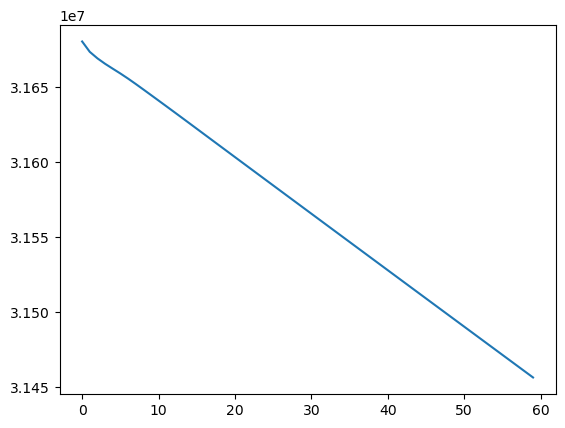

In [151]:
N_total = np.sum(N_females[1:,1:], 0) + np.sum(N_males[1:,1:], 0)
plt.plot(N_total)

### Parent-offspring probabilities

The number of offspring born to parents of sex g in year $b_2$ is:

$$
\sum_{a=2}^{37} N_{a, b_2, g}f(a,g)
$$

An individual that was born in year $b_1 < b_2$ was $b_2 - b1 + 1$ years old in year $b_2$ and on average had $f(b_2 - b_1 + 1,g)$ offspring in year $b_2$.

An individual born in year $b_1$ and sampled in year $y_1$ can be the parent of an individual born in year  $b_2$ if:

- Parent was sampled in the year of the offspring’s birth or after: $y_1 \geq b2$
- Parent was sampled within its lifetime: $b_1 < y_1 \leq b_1 + 37$
- Offspring was born before the parent died: $b_2 \leq b_1 + 37$

So, the parent-offspring pair probability for parent birth year, parent capture year, offspring birth year, and parent sex $b_1, y_1, b_2, g$ is:

$$
\frac{f(b_2 - b_1 + 1, g)}{\sum_{a=2}^{37} N_{a, b_2, g}f(a,g)}, y_1 \geq b_2, b_1 < y_1 \leq b_1 + 37, b_2 \leq b_1 + 37
$$

In [160]:
# Calculating probability of parent-offspring pair
b1 = 20 # Parent birth year
y1 = 50 # Parent capture year
b2 = 40 # Offspring birth year
g = 1 # Parent sex
max_a = 37
def POP_probability(b1, y1, b2, g, max_a = 37):
    ages = np.arange(1,max_a + 1)
    if y1 >= b2 and b1 < y1 <= b1 + max_a and b1 <= b2 <= b1 + max_a:
        if g == 1:
            nug1_tilda = nu11_tilda
            nug2_tilda = nu12_tilda
            N_g = N_females
        if g ==2:
            nug1_tilda = nu21_tilda
            nug2_tilda = nu22_tilda
            N_g = N_males
        # Total reproductive output in the offpsring birth year of all individuals of gender g alive at that time
        erro = np.sum([f(a, nug1_tilda, nug2_tilda) * N_g[a, b2] for a in ages[2:]])
        # Fecundity of parent in offspring birth year
        f_parent = f(b2 - b1 + 1, nug1_tilda, nug2_tilda)
        p_pop = f_parent/erro
    else:
        p_pop = 0
    return(p_pop)
print(POP_probability(b1, y1, b2, g))

1.5438035085985209e-07


### Half sibling probabilities

Older sibling birth year $b_1$, younger sibling birth year $b_2$, parent sex $g$

In year $b_1$, there are $N_a, b_1, g$ potential parents of age $a$ and sex $g$.

The probability that one of these potential parents is the parent of the older sibling is:

$$
\frac{f(a, g)}{\sum_{a'=2}^{37} N_{a', b_1, g}f(a',g)}
$$

Between the reproduction step of year $b_1$ and the reproduction step of year $b_2$, an individual goes through the survival step in years $y\in [b_1, ..., b_2 - 1]$. If the individual is of age $a$ in year $b_1$, then it is age $a^* = a + y - b_1 \in [a,...,a + b_2 - 1 - b_1]$. So the probability that the potential parent survives until the reproduction step of the year the younger sibling is born is:

$$
\prod_{y = b_1}^{b_2-1}S_{a + y - b_1}
$$

In the year of the younger siblings birth, the potential parent is age $a + b_2 - b_1$.

The probability the potential parent is the sibling of the younger sibling is:

$$
\frac{f(a + b_2 - b_1, g)}{\sum_{a'=2}^{37} N_{a', b_2, g}f(a',g)}
$$

So the half-sibling probability is:

$$
\sum_{a = 1}^{37} \frac{f(a, g)}{\sum_{a'=2}^{37} N_{a', b_1, g}f(a',g)}\prod_{y = b_1}^{b_2-1}S_{a + y - b_1}\frac{f(a + b_2 - b_1, g)}{\sum_{a'=2}^{37} N_{a', b_2, g}f(a',g)}
$$

In [161]:
# Calculating probability of half-sibling pair
b1 = 10 # Older sibling birth year
b2 = 40 # Younger sibling birth year
g = 1 # Parent sex
max_a = 37
def HS_probability(b1, b2, g, max_a = 37):
    ages = np.arange(1,max_a + 1)
    if g == 1:
        nug1_tilda = nu11_tilda
        nug2_tilda = nu12_tilda
        N_g = N_females
    if g ==2:
        nug1_tilda = nu21_tilda
        nug2_tilda = nu22_tilda
        N_g = N_males
    p_hs = 0
    # Sum over all possible ages
    for a in ages:
        # Total number of individuals of sex g and age a in the older sibling birth year
        N_ab1g = N_g[a, b1]
        # Total expected reproductive output of all individuals of sex g in the older sibling birth year
        erro_b1 = np.sum([f(a_prime, nug1_tilda, nug2_tilda) * N_g[a_prime, b1] for a_prime in ages[2:]])
        # Probability that an individual of age a in the older sibling birth year is the parent of the older sibling
        p_parent_older_sib = f(a, nug1_tilda, nug2_tilda)/erro_b1
        # Probability that an individual of age a in the older sibling birth year survived until the younger sibling birth year
        p_survived = np.prod([S(a + y - b1, eta1_tilda, eta2_tilda, eta3_tilda, c) for y in np.arange(b1, b2)])
        # Total expected reproductive output of all individuals of sex g in the younger sibling birth year
        erro_b2 = np.sum([f(a_prime, nug1_tilda, nug2_tilda) * N_g[a_prime, b2] for a_prime in ages[2:]])
        # Probability that an individual of age a in the older sibling birth year is the parent of the younber sibling
        p_parent_younger_sib = f(a + b2 - b1, nug1_tilda, nug2_tilda)/erro_b2
        p_hs += N_ab1g * p_parent_older_sib * p_survived * p_parent_younger_sib
    return(p_hs)
print(HS_probability(b1, b2, g, max_a))


3.406789234741717e-12


In [ ]:
# Define the log likelihood function
# Parameters to estimate: R0, eta1_tilda, eta2_tilda, eta3_tilda, nu11_tilda, nu12_tilda, nu21_tilda, nu22_tilda
# Observations: parent_counts, sibling_counts
max_a = 37
max_t = 60
R0 = 15
eta1_tilda = np.exp(-2.904)
eta2_tilda = 1 + np.exp(0.586)
eta3_tilda = np.exp(-2.579)
c = 1.111
nu11_tilda = 1.264
nu12_tilda = 5.424
nu21_tilda = 1.868
nu22_tilda = 6.5
N_females, N_males = N(max_a, max_t, R0, eta1_tilda, eta2_tilda, eta3_tilda, nu11_tilda, nu12_tilda, c)



In [ ]:
def ll(params, parent_counts, sibling_counts):
    """
    Log likelihood function of params given parent and sibling pair counts
    """
    # Unpack the parameters
    R0, eta1_tilda, eta2_tilda, eta3_tilda, nu11_tilda, nu12_tilda, nu21_tilda, nu22_tilda = params
    

In [137]:
np.arange(b1, b2)

array([10, 11])

In [27]:
eta1 = np.exp(-2.904)
eta2 = 1 + np.exp(0.586)
eta3 = np.exp(-2.579)
nu1 = 1.264
nu2 = 5.424
print(S(10, eta1, eta2, eta3))
print(f(3, nu1, nu2))

0.17359934371473326
0.04461961540616243
